# Gaussian linear regression

In [1]:
%pip install --upgrade pip
# freeze blackjax to the last commit as of the time of writing
%pip install -q git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
%pip install --upgrade -q git+https://github.com/kuperov/welford.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip freeze

absl-py==1.4.0
anyio==3.6.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
arviz==0.15.1
asttokens==2.2.1
attrs==22.2.0
backcall==0.2.0
beautifulsoup4==4.11.2
blackjax @ git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
bleach==6.0.0
cffi==1.15.1
chex==0.1.6
cloudpickle==2.2.1
comm==0.1.2
contourpy==1.0.7
cycler==0.11.0
debugpy==1.6.6
decorator==5.1.1
defusedxml==0.7.1
diag==0.0.2
dm-tree==0.1.8
executing==1.2.0
fastjsonschema==2.16.3
fastprogress==1.0.3
fonttools==4.39.0
fqdn==1.5.1
gast==0.5.3
h5netcdf==1.1.0
h5py==3.8.0
idna==3.4
ipykernel==6.21.3
ipython==8.11.0
ipython-genutils==0.2.0
isoduration==20.11.0
jax==0.4.5
jaxlib==0.4.4
jaxopt==0.6
jedi==0.18.2
Jinja2==3.1.2
jsonpointer==2.3
jsonschema==4.17.3
jupyter-events==0.6.3
jupyter_client==8.0.3
jupyter_core==5.2.0
jupyter_server==2.4.0
jupyter_server_terminals==0.4.4
jupyterlab-pygments==0.2.2
kiwisolver==1.4.4
MarkupSafe==2.1.2
matplotlib==3.7.1
matplotlib-inline==0.1.6
mi

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
for i, dev in enumerate(jax.devices()):
  print(f"Device {i}. {dev}")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Device 0. TFRT_CPU_0


In [4]:
import blackjax as bj
assert bj.__version__ == "0.9.7.dev153+g7100bca"
from blackjax.mcmc.hmc import HMCState

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from tensorflow_probability.substrates import jax as tfp
from typing import NamedTuple, Dict, Callable, Tuple
import welford as wf
from functools import partial
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import ticker
tfd = tfp.distributions
tfb = tfp.bijectors

In [6]:
class Theta(NamedTuple):
    beta: jax.Array
    sigsq: jax.Array

sigsq_t = tfb.Exp()

def generate(key: jax.random.KeyArray, N: int, beta0: jax.Array, sigsq0: jax.Array):
    y_key, X_key = jax.random.split(key)
    p = len(beta0)
    X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
    y = X@beta0 + jnp.sqrt(sigsq0)*tfd.Normal(loc=0, scale=1.).sample(sample_shape=(N,), seed=y_key)
    return y, X

def to_constrained(theta: Theta) -> Theta:
    return Theta(beta=theta.beta, sigsq=sigsq_t.forward(theta.sigsq))

def get_model(y, X, K):
    N, p = X.shape
    # use exp to transform sigsq to unconstrained space

    beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10*jnp.ones(p))
    sigsq_prior = tfd.InverseGamma(2.0, 2.0)

    def logjoint_density(theta: Theta, fold_id: int, model_id: int, prior_only: bool = False) -> jax.Array:
        """Log joint density for a given fold.
        
        Args:
            theta: model parameters
            fold_id: zero-based fold id for training set, -1 for entire dataset
            model_id: 0 for model A, 1 for model B
            prior_only: if True, only return prior density
        
        Returns:
            log density
        """
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
        # prior is same for all folds
        lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
        ll_mask = ((jnp.arange(N) % K) != fold_id).astype(jnp.float32)  # select fold
        # model A has all the predictors, model B is missing the last predictor
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        eps = (y - X @ (theta.beta * beta_mask))
        ll_contribs = tfd.Normal(loc=0., scale=jnp.sqrt(sigsq)).log_prob(eps)
        ll = (ll_mask * ll_contribs).sum() * (not prior_only)
        return lp + ll + sigsq_ldj

    # predictive density log p(y_train|theta)
    def log_pred(theta: Theta, fold_id: int, model_id: int):
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        pred_mask = ((jnp.arange(N) % K) == fold_id).astype(jnp.float32)
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
        return (pred_mask * ll_contribs).sum()

    # random initialization in the constrained parameter space
    def make_initial_pos(key: jax.random.KeyArray):
        k1, k2 = jax.random.split(key)
        theta = Theta(
            beta=jax.random.normal(key=k1, shape=(p,)),
            sigsq=jax.random.normal(key=k2))
        return theta

    return logjoint_density, log_pred, make_initial_pos


In [7]:
num_folds=10
num_models=2
num_chains=4
batch_size=200
num_integration_steps=10

total_batches=40
warmup_iter=1_000

random_seed=123
inference_key, data_key=jax.random.split(jax.random.PRNGKey(random_seed))

y, X = generate(key=data_key,
                N = 100,
                beta0 = jnp.array([1.0, 1.0, 1.0, 0.4]),
                sigsq0 = jnp.array(2.0))
logjoint_density, log_pred, make_initial_pos = get_model(y, X, num_folds)

In [8]:
@jax.jit
def find_initial_params(rng_key, fold_id, model_id):
    """Use adam to approximately maximize the log joint density."""""
    import optax
    params = make_initial_pos(rng_key)
    optimizer = optax.adam(learning_rate=1.0)
    f = lambda x: -logjoint_density(x, fold_id, model_id, prior_only=False)
    state = optimizer.init(params)
    def loop_body(i, carry):
        params, state = carry
        _, grads = jax.value_and_grad(f)(params)
        updates, new_state = optimizer.update(grads, state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state
    params, _ = jax.lax.fori_loop(0, 50, loop_body, (params, state))
    return params


Window adaptation to find a good step size, inverse mass matrix for full-data model

In [9]:
class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    pred_ws: wf.LogWelfordState  # accumulator for log predictive
    pred_bws: wf.BatchLogWelfordState  # batch accumulator for log predictive, size b
    pred_bws3: wf.BatchLogWelfordState  # batch accumulator for log predictive, size floor(b/3)
    divergences: jax.Array  # divergence counts (int array)

def init_ext_state(state, rng_key):
    """Create initial state"""
    return ExtendedState(
        state=state,
        rng_key=rng_key,
        pred_ws=wf.log_welford_init(()),
        pred_bws=wf.batch_log_welford_init((), batch_size),
        pred_bws3=wf.batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

def reset_ext_state(state):
    """Reset averages after warmup"""
    return ExtendedState(
        state=state.state,
        rng_key=state.rng_key,
        pred_ws=wf.log_welford_init(()),
        pred_bws=wf.batch_log_welford_init((), batch_size),
        pred_bws3=wf.batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

@partial(jax.jit, static_argnames=['num_samples', 'is_online'])
def inference_loop(ext_states, fold_id, model_id, num_samples, is_online) -> Tuple[ExtendedState, HMCState]:
    hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    def one_chain_inference_loop(state):  # Single chain inference loop
        def one_mcmc_step(ext_state: ExtendedState, _idx)  -> Tuple[ExtendedState, HMCState]:
            # Single chain, single MCMC step.
            iter_key, carry_key = jax.random.split(ext_state.rng_key)
            chain_state, chain_info = hmc.step(iter_key, ext_state.state)
            elpd_contrib = log_pred(chain_state.position, fold_id, model_id)
            carry_state = ExtendedState(
                state=chain_state,
                rng_key=carry_key,
                pred_ws=wf.log_welford_add(elpd_contrib, ext_state.pred_ws),
                pred_bws=wf.batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                pred_bws3=wf.batch_log_welford_add(elpd_contrib, ext_state.pred_bws3),
                divergences=ext_state.divergences + chain_info.is_divergent,
            )
            if is_online:
                return carry_state, None  # don't retain chain trace
            else:
                return carry_state, chain_state.position
        next_state, trace = jax.lax.scan(one_mcmc_step, state, jnp.arange(num_samples))
        return next_state, trace
    # run all chains for this fold in parallel
    return jax.vmap(one_chain_inference_loop)(ext_states)

Initialize inference

In [10]:
def sense_check_init_pos(fm_init_pos):
    # sense check initial positions generate reasonable log likelihoods
    print("log joint density sense checks")
    m0ljd = jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, -1, 0)
    m1ljd = jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, -1, 1)
    print(f"ljd mean m0: {jnp.mean(m0ljd):.2f} m1: {jnp.mean(m1ljd):.2f} diff (m0 - m1): {jnp.mean(m1ljd - m0ljd):.2f}")
    for m in range(num_models):
        print()
        fljds = jnp.array([
            jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, f, m).mean()
            for f in range(num_folds)])
        print(f"ljd m{m} folds: {', '.join([f'{f:.2f}' for f in fljds])}")
        flprds = jnp.array([
            jax.vmap(logjoint_density, in_axes=(0, None, None, None))(fm_init_pos, f, m, True).mean()
            for f in range(num_folds)])
        print(f"lpriord m{m} folds: {', '.join([f'{f:.2f}' for f in flprds])}")
        flpds = jnp.array([
            jax.vmap(log_pred, in_axes=(0, None, None))(fm_init_pos, f, m).mean()
            for f in range(num_folds)])
        print(f"lpredd m{m} folds: {', '.join([f'{f:.2f}' for f in flpds])}")
        print(f"lpredd+ljd m{m} folds: {', '.join([f'{f:.2f}' for f in flpds+fljds])}")

## Single fold test



### Offline inference


In [11]:
state_k, sampling_k = jax.random.split(inference_key)

fold_id, model_id = 1, 0

# parameter adaptation
init_pos_1c = find_initial_params(state_k, fold_id, model_id)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
state_ks = jax.random.split(state_k, num_chains)
fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

sense_check_init_pos(fm_init_pos)

# burn-in
state, _ = inference_loop(initstate, fold_id, model_id, warmup_iter, False)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in

state, trace = inference_loop(state, fold_id, model_id, batch_size*total_batches, False)
assert jnp.all(state.divergences < 5), f"{state.divergences.sum()} divergences during inference"

# transform back to constrained parameter space
constrained_trace = jax.vmap(to_constrained)(trace)
import arviz as az
idata = az.convert_to_inference_data({v : constrained_trace[i] for i, v in enumerate(trace._fields)})

Running window adaptation



Step size = 0.6197, inv mm norm = 0.0608

log joint density sense checks
ljd mean m0: -247.34 m1: -244.86 diff (m0 - m1): 2.48

ljd m0 folds: -223.85, -223.03, -222.21, -225.05, -224.60, -223.79, -225.71, -224.61, -225.41, -223.72
lpriord m0 folds: -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92
lpredd m0 folds: -23.49, -24.31, -25.13, -22.29, -22.74, -23.55, -21.63, -22.73, -21.93, -23.62
lpredd+ljd m0 folds: -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34

ljd m1 folds: -221.79, -221.73, -219.77, -223.66, -222.05, -220.55, -223.75, -222.77, -221.75, -221.80
lpriord m1 folds: -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92
lpredd m1 folds: -23.06, -23.13, -25.09, -21.19, -22.80, -24.31, -21.10, -22.09, -23.11, -23.05
lpredd+ljd m1 folds: -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86


In [12]:
# compute predictive draws from chain
lp_draws = jax.vmap(jax.vmap(lambda x: log_pred(x, fold_id, model_id)))(trace)
# expanding means
lps_xpnd = jnp.array([logsumexp(lp_draws[:, :m]) - jnp.log(num_chains * m)
                 for m in range(batch_size, batch_size*total_batches, batch_size)])
# batch means
batch_means = lp_draws.reshape((num_chains, total_batches, batch_size)).mean(axis=2)
ses = jnp.array([jnp.std(batch_means[:, :m], ddof=1)/jnp.sqrt(batch_size/m/num_chains)
                 for m in jnp.arange(1, total_batches+1)])

In [13]:
def bsum(bs):
    # batch means of each chain
    w0 = wf.batch_log_welford_init(shape=(), batch_size=bs)
    def f(carry, x):
        return wf.batch_log_welford_add(x, carry), None
    def g(xs):
        return jax.lax.scan(f, w0, xs)
    w4, _ = jax.vmap(g)(lp_draws)
    bmeans = jax.vmap(wf.batch_log_welford_mean)(w4)
    bvars = jax.vmap(wf.batch_log_welford_var)(w4)
    print(f"batch size {bs}")
    print(f"means = {bmeans}")
    print(f"vars = {bvars + jnp.log(bs)}")

for i in [10, 50, 100, 150, 200, 500]:
    bsum(i)

batch size 10
means = [-18.39034564 -18.38079755 -18.30447522 -18.32717553]
vars = [-35.8784351  -35.88393759 -35.78168592 -35.89840591]
batch size 50
means = [-18.39034564 -18.38079755 -18.30447522 -18.32717553]
vars = [-34.57167826 -34.61135004 -34.55531219 -34.68046646]
batch size 100
means = [-18.39034564 -18.38079755 -18.30447522 -18.32717553]
vars = [-34.11198665 -34.2158396  -34.17391636 -34.23094755]
batch size 150
means = [-18.38905442 -18.38042246 -18.29808877 -18.32701696]
vars = [-33.79586592 -34.07141688 -33.93590749 -34.06727326]
batch size 200
means = [-18.39034564 -18.38079755 -18.30447522 -18.32717553]
vars = [-33.68057398 -33.85207368 -33.68653957 -33.81230023]
batch size 500
means = [-18.39034564 -18.38079755 -18.30447522 -18.32717553]
vars = [-33.4073852  -33.56158876 -33.59463843 -33.63758658]


In [15]:
# #@jax.jit
# def ess(bs):
#     # raw summary of each chain
#     n = lp_draws.size
#     w0 = wf.log_welford_init(shape=())
#     f = lambda carry, x: (wf.log_welford_add(x, carry), None)
#     w4, _ = jax.vmap(lambda xs: jax.lax.scan(f, w0, xs))(lp_draws)
#     rmeans = jax.vmap(wf.log_welford_mean)(w4)
#     #rvars = logsumexp(jax.vmap(wf.log_welford_var)(w4)) - jnp.log(num_chains)
#     rvars = wf.log_welford_var_combine(w4, ddof=1, axis=0)
#     lambdasq = rvars + jnp.log(n) - jnp.log(n-1)  # unbiased estimator
#     w0 = wf.batch_log_welford_init(shape=(), batch_size=bs)
#     f = lambda carry, x: (wf.batch_log_welford_add(x, carry), None)
#     w4, _ = jax.vmap(lambda xs: jax.lax.scan(f, w0, xs))(lp_draws)
#     bmeans = jax.vmap(wf.batch_log_welford_mean)(w4)
#     sigmasq = wf.log_welford_var_combine(w4.batches, ddof=1, axis=0) + jnp.log(bs)
#     ess = n*jnp.exp(lambdasq - sigmasq)
#     return ess, n

# print(' **** Welford estimators ****')
# for bs in [10, 50, 100, 150, 200, 500]:
#     es, n = ess(bs)
#     print(f"batch size {bs}: raw n={n}, ess={es:.0f}")

# print(' **** regular estimators ****')
# def logvar(lxs, ddof=1):
#     lsx2 = logsumexp(2*lxs)
#     lsx = logsumexp(lxs)
#     ln = jnp.log(lxs.size)
#     lnd = jnp.log(lxs.size-ddof)
#     return lsx2 + jnp.log1p(-jnp.exp(2*lsx - lsx2 - ln)) - lnd

# zs = jnp.arange(1,10)
# assert jnp.allclose(jnp.exp(logvar(jnp.log(zs))), jnp.var(zs, ddof=1))

# dc_pred = lp_draws.swapaxes(0, 1)

# for bs in [10, 50, 100, 150, 200, 500]:
#     n = dc_pred.size
#     a = dc_pred.shape[0] // bs
#     bmeans = logsumexp(dc_pred.reshape((a, bs, num_chains)), axis=1) - jnp.log(bs)
#     lsigsqhat = jnp.log(bs) + logvar(bmeans, ddof=1)
#     llambdasqhat = logvar(dc_pred, ddof=1)
#     ess = jnp.exp(jnp.log(dc_pred.size) + llambdasqhat - lsigsqhat)
#     print(f"batch size {bs}: raw n={n} ess={ess:.0f}")

# print(' **** arivz ****')
# predx = az.from_dict({'pred': lp_draws})
# azess = float(az.ess(predx, method='mean')['pred'])
# print(f'ess = {azess:.0f}')

In [16]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.092,0.178,0.764,1.436,0.008,0.006,470.0,1519.0,1.01
beta[1],1.003,0.178,0.667,1.334,0.013,0.009,193.0,292.0,1.02
beta[2],1.083,0.161,0.777,1.383,0.005,0.003,1203.0,3185.0,1.00
beta[3],0.311,0.165,-0.007,0.612,0.005,0.003,1114.0,3354.0,1.00
sigsq,2.528,0.383,1.832,3.238,0.012,0.009,1050.0,1742.0,1.01


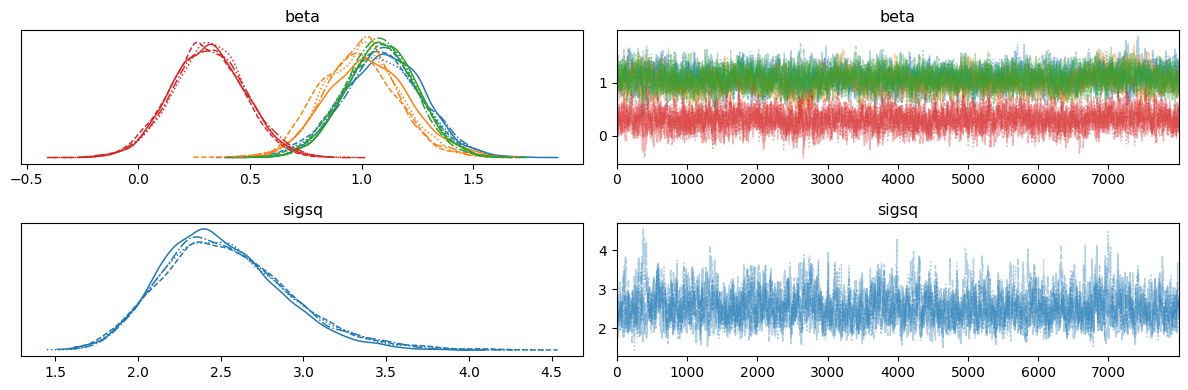

In [17]:
az.plot_trace(idata, var_names=['beta', 'sigsq'])
plt.tight_layout()

### Online inference

In [18]:
state_k, sampling_k = jax.random.split(inference_key)

fold_id, model_id = 1, 0

# parameter adaptation
init_pos_1c = find_initial_params(state_k, fold_id, model_id)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
state_ks = jax.random.split(state_k, num_chains)
fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

sense_check_init_pos(fm_init_pos)

# burn-in
state, _ = inference_loop(initstate, fold_id, model_id, warmup_iter, False)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in

logmean = []
for i in range(total_batches):
    state, _ = inference_loop(state, fold_id, model_id, batch_size, True)
    pmean = logsumexp(wf.log_welford_mean(state.pred_ws)) - jnp.log(num_chains)
    logmean.append(pmean)
assert jnp.all(state.divergences == 0), print(f"WARNING: {state.divergences.sum()} divergences")
logmean = jnp.stack(logmean)

Running window adaptation



Step size = 0.6197, inv mm norm = 0.0608

log joint density sense checks
ljd mean m0: -247.34 m1: -244.86 diff (m0 - m1): 2.48

ljd m0 folds: -223.85, -223.03, -222.21, -225.05, -224.60, -223.79, -225.71, -224.61, -225.41, -223.72
lpriord m0 folds: -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92
lpredd m0 folds: -23.49, -24.31, -25.13, -22.29, -22.74, -23.55, -21.63, -22.73, -21.93, -23.62
lpredd+ljd m0 folds: -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34, -247.34

ljd m1 folds: -221.79, -221.73, -219.77, -223.66, -222.05, -220.55, -223.75, -222.77, -221.75, -221.80
lpriord m1 folds: -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92, -15.92
lpredd m1 folds: -23.06, -23.13, -25.09, -21.19, -22.80, -24.31, -21.10, -22.09, -23.11, -23.05
lpredd+ljd m1 folds: -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86, -244.86


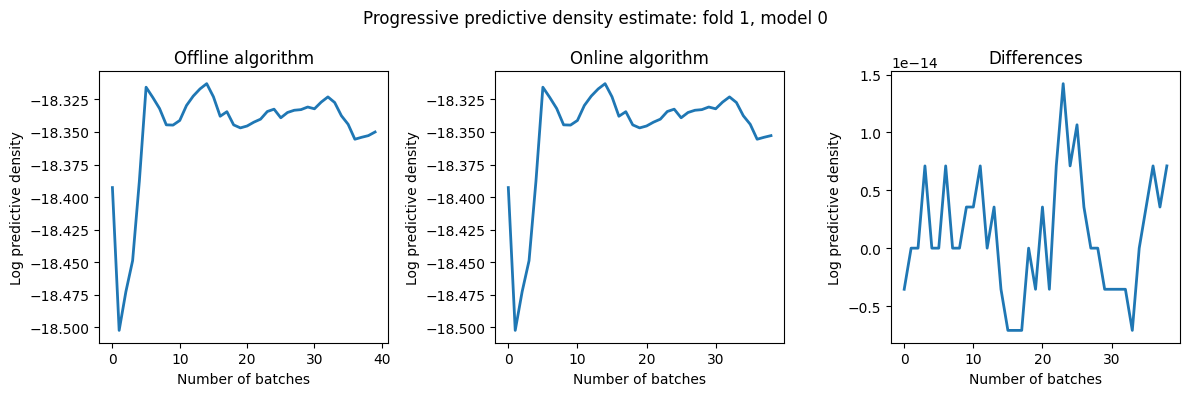

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
offline, online, diffs = axes

offline.plot(logmean, linewidth=2)
offline.set_title('Offline algorithm')

online.plot(lps_xpnd, linewidth=2)
online.set_title('Online algorithm')

diffs.plot(logmean[:-1] - lps_xpnd, linewidth=2)
diffs.set_title('Differences')

for ax in axes:
    ax.set_xlabel("Number of batches")
    ax.set_ylabel("Log predictive density")

fig.suptitle(f'Progressive predictive density estimate: fold {fold_id}, model {model_id}')
fig.tight_layout()
fig.savefig('online_vs_offline.pdf', bbox_inches=0, transparent=True)

## Online cross-validation

In [40]:
def init_one_fold(fold_id: int, model_id: int):
    fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    state_ks = jax.random.split(state_k, num_chains)
    fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
    fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
    return jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

#@partial(jax.jit, static_argnames=['ndraws'])
def cv_uncertainty_ci_logscore(state: ExtendedState, simkey: jax.random.KeyArray, d: float=0.05, ndraws: int=100):
    # model distribution incorporating CV uncertainty
    # MC (log) variance of contributions to $\hat{p}$
    mf_logbvar = wf.log_welford_var_combine(state.pred_bws.batches, axis=2, ddof=1) + jnp.log(batch_size)
    # MC (log) variance of $\hat{p}$
    mf_logbvar_mean = mf_logbvar - jnp.log(state.pred_ws.n.sum(axis=2))
    # $\log\hat{p}$
    mf_logbmean = logsumexp(wf.log_welford_mean(state.pred_bws.batches), axis=2) - jnp.log(num_chains)
    # $\var S(\hat{p})$ (delta method)
    mf_simvar = jnp.exp(mf_logbvar_mean - 2*mf_logbmean)  # delta method
    etahat_draws = (
        jnp.expand_dims(mf_logbmean, 0)
        + jnp.log(
            jnp.ones_like(mf_simvar) 
            + jnp.sqrt(mf_simvar)
                * jax.random.truncated_normal(simkey, -jnp.ones_like(mf_simvar), jnp.inf, shape=(ndraws,)+mf_simvar.shape))
    )
    # variability for individual models
    from jax.scipy.stats.norm import ppf as normq
    # sample stats for draw, model (taken over folds), on sum scale
    nfolds = etahat_draws.shape[2]
    dm_mean, dm_var = etahat_draws.sum(axis=2), nfolds*etahat_draws.var(axis=2, ddof=1)  # etahat or phat?
    # upper normal quantile for each draw
    model_std = jnp.sqrt(dm_var.mean(axis=0))
    dm_uq = normq(1-d/2, loc=dm_mean, scale=jnp.sqrt(dm_var))
    dm_lq = normq(d/2, loc=dm_mean, scale=jnp.sqrt(dm_var))
    m_uq, m_lq = dm_uq.mean(axis=0), dm_lq.mean(axis=0)
    #m_uq_wide = normq(1-d/2, loc=m_uq, scale=jnp.sqrt(#????))
    m_uq_wide, m_lq_wide = jnp.quantile(dm_uq, q=0.95, axis=0), jnp.quantile(dm_lq, q=0.05, axis=0)
    m_uq_narrow, m_lq_narrow = jnp.quantile(dm_uq, q=0.05, axis=0), jnp.quantile(dm_lq, q=0.95, axis=0)
    # variability for difference
    ddiff_mean = dm_mean[:,0] - dm_mean[:,1]
    ddiff_var = nfolds*(etahat_draws[:,0,:] - etahat_draws[:,1,:]).var(axis=1, ddof=1)
    diff_std = jnp.sqrt(ddiff_var.mean())
    ddiff_uq = normq(1-d/2, loc=ddiff_mean, scale=jnp.sqrt(ddiff_var))
    ddiff_lq = normq(d/2, loc=ddiff_mean, scale=jnp.sqrt(ddiff_var))
    diff_uq, diff_lq = ddiff_uq.mean(), ddiff_lq.mean()
    diff_uq_wide, diff_lq_wide = jnp.quantile(ddiff_uq, q=0.95), jnp.quantile(ddiff_lq, q=0.05)
    diff_uq_narrow, diff_lq_narrow = jnp.quantile(ddiff_uq, q=0.05), jnp.quantile(ddiff_lq, q=0.95)
    return dict(
        diff_uq=diff_uq,
        diff_lq=diff_lq,
        diff_std=diff_std,
        model_std=model_std,
        m_uq=m_uq,
        m_lq=m_lq,
        m_uq_wide=m_uq_wide,
        m_lq_wide=m_lq_wide,
        m_uq_narrow=m_uq_narrow,
        m_lq_narrow=m_lq_narrow,
        diff_uq_wide=diff_uq_wide,
        diff_lq_wide=diff_lq_wide,
        diff_uq_narrow=diff_uq_narrow,
        diff_lq_narrow=diff_lq_narrow
    )

#@jax.jit
def inference_stats(state):
    # inference statistics
    logmean = logsumexp(wf.log_welford_mean(state.pred_ws), axis=2) - jnp.log(num_chains)
    model_means = logmean.sum(axis=1)
    delta = model_means[0] - model_means[1]
    # monte carlo variance for each model
    mf_logbvar = wf.log_welford_var_combine(state.pred_bws.batches, axis=2, ddof=1) + jnp.log(batch_size)
    mf_logbmean = logsumexp(wf.log_welford_mean(state.pred_bws.batches), axis=2) - jnp.log(num_chains)
    m_bvar = jnp.exp(mf_logbvar - 2*mf_logbmean).sum(axis=1)  # delta method, sum over folds
    mf_n = state.pred_ws.n.sum(axis=2)[:,0]  # total draw count per model, fold
    # mcse at the model level (2-vector) for log score
    mcse = jnp.sqrt(m_bvar / mf_n)
    # raw per-model variance
    mf_logvar = wf.log_welford_var_combine(state.pred_ws, axis=2, ddof=1)
    mf_logmean = logsumexp(wf.log_welford_mean(state.pred_ws), axis=2) - jnp.log(num_chains)
    m_var = jnp.exp(mf_logvar - 2*mf_logmean).sum(axis=1)  # delta method, sum over folds
    ndraws = state.pred_ws.n.sum(axis=2)[0,0]
    # by chain independence, we can just add all the variances
    ess = num_chains * ndraws * m_bvar.sum() / m_var.sum()
    # combined rhat
    W = jnp.exp(wf.log_welford_var(state.pred_ws) - 2*wf.log_welford_mean(state.pred_ws)).mean(axis=2)
    B = jnp.var(wf.log_welford_mean(state.pred_ws), ddof=1, axis=2)
    rhat_eta = (ndraws/(ndraws-1) * W.sum() + 1/ndraws * B.sum())/W.sum()
    # mcse for difference
    differr = jnp.sqrt(jnp.sum(mcse**2))
    return dict(
        logmean=logmean,
        model_means=model_means,
        delta=delta,
        mcse=mcse,
        ess=ess,
        rhat_eta=rhat_eta,
        differr=differr)

Inference procedure

In [41]:
state_k, sampling_k, uncertainty_sim_k = jax.random.split(inference_key, 3)

# automatic parameter adaptation - just model 0 and full data
init_pos_1c = find_initial_params(state_k, -1, 0)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, "
      f"inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}\n")

# dimensions models x folds x chains x param dimension
model_ids, fold_ids = jnp.arange(num_models), jnp.arange(num_folds)
init_state = jax.vmap(lambda model_id: jax.vmap(init_one_fold, in_axes=(0, None))(fold_ids, model_id))(model_ids)
def model_inference_loop(state, model_id, iter):
    return jax.vmap(lambda state, fold_id: inference_loop(state, fold_id, model_id, iter, True))(state, fold_ids)
grand_inference_loop = jax.vmap(model_inference_loop, in_axes=(0, 0, None))

# burn-in
# state, _ = grand_inference_loop(init_state, models, warmup_iter)
# state = jax.vmap(jax.vmap(jax.vmap(reset_ext_state)))(state)  # discard values accumulated during burn-in

state = init_state
res = defaultdict(list)  # track optional O(N) state for making plots
for i in range(total_batches):
    state, _ = grand_inference_loop(state, model_ids, batch_size)
    for key, stat in inference_stats(state).items():
        res[key].append(stat)
    for key, stat in cv_uncertainty_ci_logscore(state, uncertainty_sim_k).items():
        res[key].append(stat)
assert jnp.all(state.divergences == 0), print(f"WARNING: {state.divergences.sum()} divergences")
res = {k: jnp.stack(res[k]) for k in res}  # results as arrays

Running window adaptation



Step size = 0.6282, inv mm norm = 0.0573



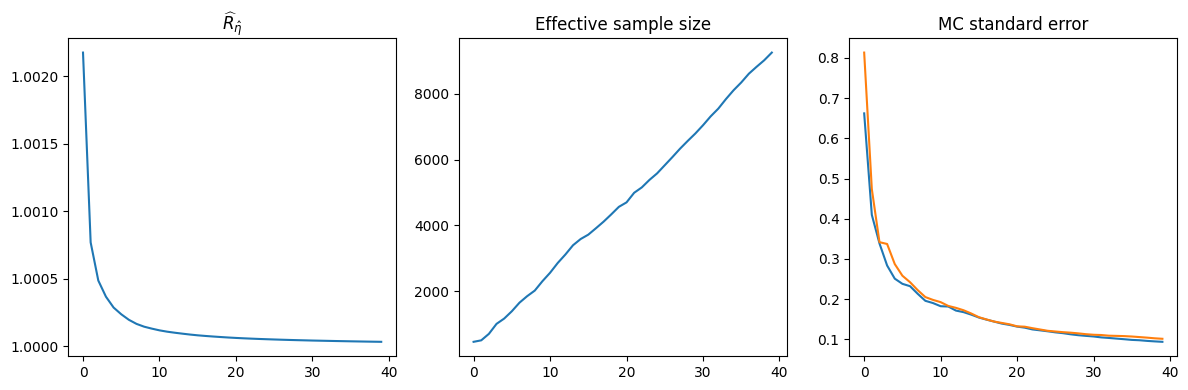

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
prhat, pess, pmcse = axes
prhat.plot(res['rhat_eta'])
prhat.set_title(r"$\widehat{R}_{\hat{\eta}}$")
pess.plot(res['ess'])
pess.set_title("Effective sample size")
pmcse.plot(res['mcse'])
pmcse.set_title("MC standard error")
fig.tight_layout()

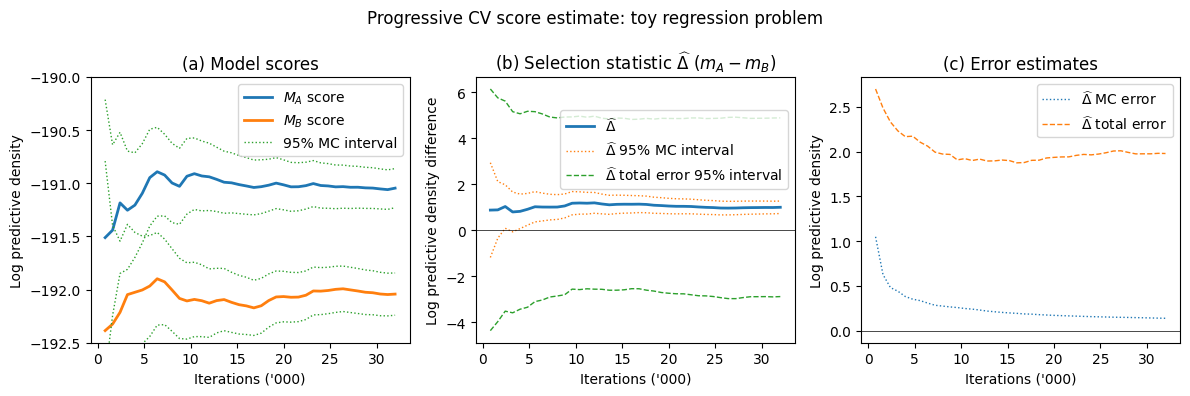

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
models, diffs, errs = axes
it = jnp.arange(1, total_batches+1) * batch_size * num_chains

zcrit = jax.scipy.stats.norm.ppf(0.975)

mA = models.plot(it, res['model_means'][:,0], linewidth=2)
mB = models.plot(it, res['model_means'][:,1], linewidth=2)
_c = models.plot(it, res['model_means'][:,0] + zcrit*res['mcse'][:,0], linewidth=1, linestyle=':')
models.plot(it, res['model_means'][:,0] - zcrit*res['mcse'][:,0], linewidth=1, linestyle=':', color=_c[0].get_color())
models.plot(it, res['model_means'][:,1] + zcrit*res['mcse'][:,1], linewidth=1, linestyle=':', color=_c[0].get_color())
models.plot(it, res['model_means'][:,1] - zcrit*res['mcse'][:,1], linewidth=1, linestyle=':', color=_c[0].get_color())
models.get_yaxis().get_major_formatter().set_useOffset(False)
models.legend([mA[0], mB[0], _c[0]], ['$M_A$ score', '$M_B$ score', '95% MC interval'])
models.set_title('(a) Model scores')
models.set_ylabel("Log predictive density")
models.set_ylim(-192.5, -190.)

_m = diffs.plot(it, res['delta'], linewidth=2)
_c = diffs.plot(it, res['delta'] + zcrit*res['differr'], linewidth=1, linestyle=':')
diffs.plot(it, res['delta'] - zcrit*res['differr'], linewidth=1, linestyle=':', color=_c[0].get_color())
_cv = diffs.plot(it, res['diff_uq'], linewidth=1, linestyle='--')
diffs.plot(it, res['diff_lq'], linewidth=1, linestyle='--', color=_cv[0].get_color())
diffs.set_title(r'(b) Selection statistic $\widehat{\Delta}$ ($m_A - m_B$)')
diffs.legend(
    [_m[0], _c[0], _cv[0]],
    [r'$\widehat{\Delta}$', r'$\widehat{\Delta}$ 95% MC interval', r'$\widehat{\Delta}$ total error 95% interval'],
    loc='best',
    bbox_to_anchor=(0., 0., 1., .9))
diffs.set_ylabel("Log predictive density difference")
diffs.axhline(0, linewidth=0.5, color='k')

_mc = errs.plot(it, res['differr'], linewidth=1, linestyle=':')
_diff_cv = errs.plot(it, res['diff_std'], linewidth=1, linestyle='--')
#_model0_cv = errs.plot(iter, model_std[:,0], linewidth=1, linestyle='--')
#_model1_cv = errs.plot(iter, model_std[:,1], linewidth=1, linestyle='--')
errs.legend([_mc[0], _diff_cv[0], #_model0_cv[0], _model1_cv[0]
             ],
            [r'$\widehat{\Delta}$ MC error', r'$\widehat{\Delta}$ total error', 
             #r'$M_A$ total error', r'$M_B$ error'
             ])
errs.set_title('(c) Error estimates')
errs.set_ylabel("Log predictive density")
errs.axhline(0, linewidth=0.5, color='k')

fmt = ticker.FuncFormatter(lambda x, pos: f'{x/1e3:.0f}')
for ax in axes:
    ax.set_xlabel("Iterations ('000)")
    ax.xaxis.set_major_formatter(fmt)

fig.suptitle(f'Progressive CV score estimate: toy regression problem')
fig.tight_layout()
fig.savefig('reg_cmp.pdf', bbox_inches=0, transparent=True)

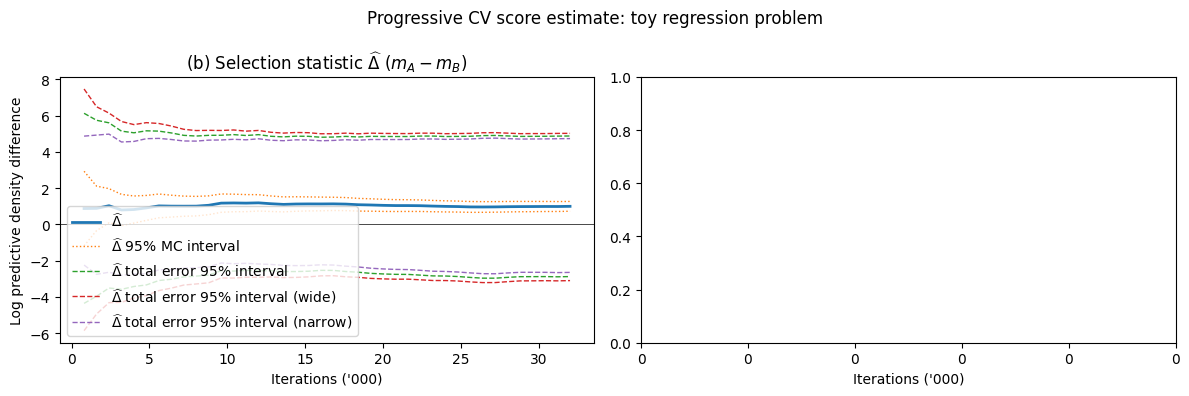

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
diffs, rhats = axes
it = jnp.arange(1, total_batches+1) * batch_size * num_chains

zcrit = jax.scipy.stats.norm.ppf(0.975)

_m = diffs.plot(it, res['delta'], linewidth=2)
_c = diffs.plot(it, res['delta'] + zcrit*res['differr'], linewidth=1, linestyle=':')
diffs.plot(it, res['delta'] - zcrit*res['differr'], linewidth=1, linestyle=':', color=_c[0].get_color())

_cv = diffs.plot(it, res['diff_uq'], linewidth=1, linestyle='--')
diffs.plot(it, res['diff_lq'], linewidth=1, linestyle='--', color=_cv[0].get_color())

_cvw = diffs.plot(it, res['diff_uq_wide'], linewidth=1, linestyle='--')
diffs.plot(it, res['diff_lq_wide'], linewidth=1, linestyle='--', color=_cvw[0].get_color())

_cvn = diffs.plot(it, res['diff_uq_narrow'], linewidth=1, linestyle='--')
diffs.plot(it, res['diff_lq_narrow'], linewidth=1, linestyle='--', color=_cvn[0].get_color())

diffs.set_title(r'(b) Selection statistic $\widehat{\Delta}$ ($m_A - m_B$)')
diffs.legend(
    [_m[0], _c[0], _cv[0], _cvw[0], _cvn[0]],
    [r'$\widehat{\Delta}$', r'$\widehat{\Delta}$ 95% MC interval', r'$\widehat{\Delta}$ total error 95% interval',
     r'$\widehat{\Delta}$ total error 95% interval (wide)', r'$\widehat{\Delta}$ total error 95% interval (narrow)'],
    loc='best',
    bbox_to_anchor=(0., 0., 1., .9))
diffs.set_ylabel("Log predictive density difference")
diffs.axhline(0, linewidth=0.5, color='k')

fmt = ticker.FuncFormatter(lambda x, pos: f'{x/1e3:.0f}')
for ax in axes:
    ax.set_xlabel("Iterations ('000)")
    ax.xaxis.set_major_formatter(fmt)

fig.suptitle(f'Progressive CV score estimate: toy regression problem')
fig.tight_layout()
fig.savefig('reg_cmp.pdf', bbox_inches=0, transparent=True)